### Analysis of anonymity of data from China


sourse: https://github.com/beoutbreakprepared/nCoV2019


In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import csv
import operator

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [252]:
# Helper functions for use later

def naToStr(df, columns):
    '''Convert the na/nan values in a pd dataframe to the string "NaN".'''
    for col in columns:
        df.loc[df[col].isna(), col] = 'NaN'
        
def strToNa(df, columns):
    '''Convert the string values "NaN" back to actual nan'''
    for col in columns:
        df.loc[df[col] == 'NaN', col] = np.nan
        
def oneHotEncoding(df, columns):
    '''Perform one-hot encoding for given columns'''
    d = pd.get_dummies(df[columns], drop_first = True)
    df[d.columns] = d
    df.drop(columns, axis = 1, inplace = True)
        
def imputeMeanWithNA(df, column):
    '''Provides one method to fix missing value for a quantitative column.
    Creates a new 0/1 column indicating whether the original column was na/nan,
    and imputes the mean to the original column where there were na/nan values.
    '''
    df[column + ' NaN'] = df[column].isna().astype(int)
    df.loc[df[column].isna(), column] = df[column].mean()

In [161]:
df = pd.read_csv('latestdata.csv')

/Users/qiang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [162]:
pd.set_option('display.max_columns', None)
df

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,mainland via the Lok Ma Chau border crossing,NaN,Case 55;,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8051.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8978.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,201.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10115.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7079.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442310,007-99995,NaN,NaN,Milano,Lombardia,Italy,45.465890,9.121072,admin2,NaN,NaN,30.03.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://raw.githubusercontent.com/pcm-dpc/COVI...,NaN,NaN,NaN,NaN,NaN,NaN,Milano,Lombardia,Italy,6195.0,TR,False
442311,007-99996,NaN,NaN,Milano,Lombardia,Italy,45.465890,9.121072,admin2,NaN,NaN,30.03.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://raw.githubusercontent.com/pcm-dpc/COVI...,NaN,NaN,NaN,NaN,NaN,NaN,Milano,Lombardia,Italy,6195.0,TR,False
442312,007-99997,NaN,NaN,Milano,Lombardia,Italy,45.465890,9.121072,admin2,NaN,NaN,30.03.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://raw.githubusercontent.com/pcm-dpc/COVI...,NaN,NaN,NaN,NaN,NaN,NaN,Milano,Lombardia,Italy,6195.0,TR,False
442313,007-99998,NaN,NaN,Milano,Lombardia,Italy,45.465890,9.121072,admin2,NaN,NaN,30.03.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://raw.githubusercontent.com/pcm-dpc/COVI...,NaN,NaN,NaN,NaN,NaN,NaN,Milano,Lombardia,Italy,6195.0,TR,False


Note: I tried to detect corrupted data here, but while the codes we used in pset3 detect corrupted lines, they don't seem like so when further examined. Thus, I didn't include the part doing corryption detection here.


#### Here we want to change the dates to date objects

Since here the dates are listed in day-month-year order, we need to adjust them a bit. Also, some dates are listed as a range, in which case we take the first date in the range.

In [163]:
date_confirmation_new  =[]
for i in df.date_confirmation:
    dd = str(i)
    if len(dd) == 3:
        date_confirmation_new.append(np.NaN)
    else:
        date_confirmation_new.append(dd[3:5]+'.'+dd[0:2]+dd[5:10])

df['date_confirmation_new'] = date_confirmation_new
df['date_confirmation_new'] = pd.DatetimeIndex(df['date_confirmation_new'])


date_admission_hospital  =[]
for i in df.date_admission_hospital:
    dd = str(i)
    if len(dd) == 3:
        date_admission_hospital.append(np.NaN)
    else:
        date_admission_hospital.append(dd[3:5]+'.'+dd[0:2]+dd[5:10])

df['date_admission_hospital_new'] = date_admission_hospital
df['date_admission_hospital_new'] = pd.DatetimeIndex(df['date_admission_hospital_new'])



In [164]:
l = []
for i in df['date_onset_symptoms']:
    l.append(len(str(i)))
    
ind = [i != 3 and i != 10 and i!=23and i!=11  for i in l]
#we see that the only one with problem is row 3483
df['date_onset_symptoms'][3483] = '20.05.2020'

/Users/qiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [165]:
date_onset_symptoms  =[]
for i in df.date_onset_symptoms:
    dd = str(i)
    if len(dd) == 3:
        date_onset_symptoms.append(np.NaN)
    else:
        date_onset_symptoms.append(dd[3:5]+'.'+dd[0:2]+dd[5:10])

df['date_onset_symptoms_new'] = date_onset_symptoms
df['date_onset_symptoms_new'] = pd.DatetimeIndex(df['date_onset_symptoms_new'])


Now we can look at the distribution of data

In [203]:
country = []
dates_confirm = []
ncase = []

for c,dfff in df.groupby('country'):
    country.append(c)
    dates_confirm.append(dfff)
    ncase.append(len(dfff))
    
neworder = np.argsort(ncase)[::-1]
country = [country[i] for i in neworder]
dates_confirm = [dates_confirm[i] for i in neworder] 
ncase = [ncase[i] for i in neworder] 


In [230]:
ncase[59] # this print out the number of cases confirmed in India in this dataset

37

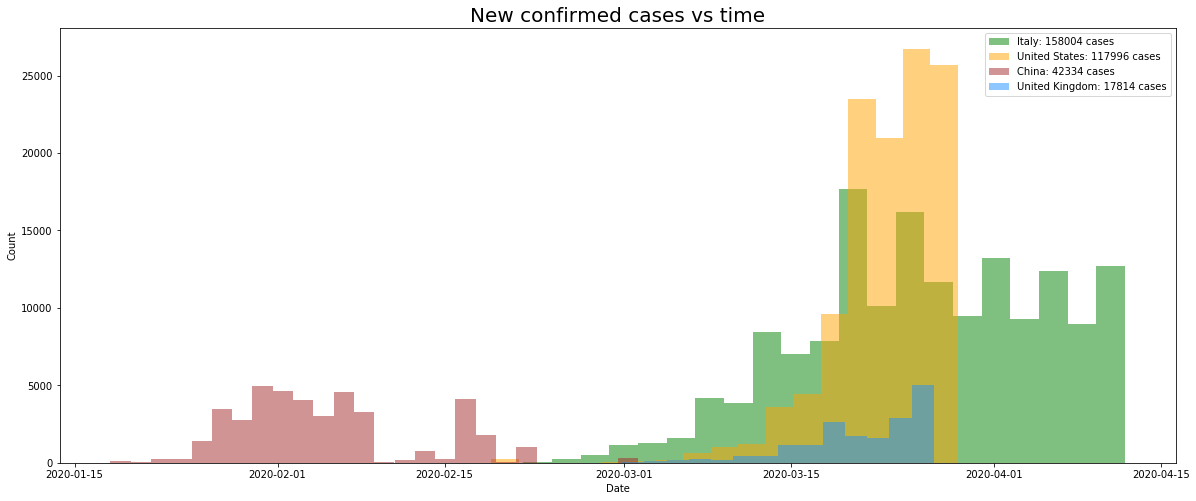

In [231]:
p_num = 4
colors = ['green','orange','brown','dodgerblue','red']
legends = [str(country[i]) + ': ' + str(ncase[i])+' cases' for i in range(len(country))]
plt.figure(figsize = [20,8])
for i in range(p_num):
    plt.hist(dates_confirm[i]['date_confirmation_new'],bins = 30,alpha = .5,color = colors[i])
plt.legend(legends[:p_num])
plt.xlabel('Date')
plt.ylabel('Count')
_ = plt.title('New confirmed cases vs time',size = 20)

In [236]:
max(dates_confirm[0]['date_confirmation_new'])

Timestamp('2020-04-12 00:00:00')

Here we print out the confirmed dates for the 4 countries with most data points. We can see that the updates for each contry continue to a different date. We will for now concentrate on the confirmed cases in China, but might work on data from other countries too.

Notice that The dataset contains 117,996 cases for United States. Given that the latest date for confirmed case in the dataset is '2020-03-29' and from https://covidtracking.com/data/us-daily we see that there are in total 144,369 confirmed cases in United States, we know that the dataset contains a reasonable large amount of data here.

Also, we have 158,004 data points for Italy. Given that the latest date for confirmed case in the dataset is '2020-04-12' and from https://coronavirus.1point3acres.com/zh/world we see that there are in total 159,516 confirmed cases in Italy, we know that the dataset contains a reasonable large amount of data here.


At this point, we will focus on Chinese data only. As the dates are transfered properly. We keep the other variables unachanged for now and want to examine the distribution of data a little bit.


In [356]:
dfc = dates_confirm[2]
dfc=dfc.reset_index(drop = True)

In [310]:
print('There are ', len(dfc.source.unique()),'sourses from which the data are collected.')

There are  667 sourses from which the data are collected.


In [311]:
max(dates_confirm[2]['date_confirmation_new'])

Timestamp('2020-03-09 00:00:00')

From http://weekly.chinacdc.cn/news/TrackingtheEpidemic.htm we see that there are 80,735 total confirmed cases till 2020-03-09, which is the lated confimed date for Chinese cases that we see in this dataset. As we have 42,334 data points for Chinese data, we still have a large amount of data points here. 

As explaned in the paper introducing this data set: various data sourses were used to collect data here and additional information was found through online reports, mainly news aggregators. Though there are much more confirmed cases in China, they don't contain individual level information as detailed as this one. We would thus concentrate on this dataset.
 
Before we start our analysis, we would also clean up dataset a little bit. While we still keep all columns in case that some might be used later, we want to repair some values from important columns that we will use later.


In [381]:
dfc.age.unique()

array([nan, '66', '27', '17', '51', '68', '26', '30', '53', '35', '28',
       '58', '33', '50', '45', '24', '88', '29', '21', '78', '52', '60',
       '82', '7', '44', '69', '16', '47', '8', '43', '10', '55', '25',
       '38', '42', '34', '62', '39', '65', '73', '48', '54', '46', '96',
       '32', '63', '64', '1.75', '57', '41', '20', '36', '80', '70', '61',
       '56', '37', '75', '94', '1', '0.25', '22', '67', '15', '79', '23',
       '49', '40', '59', '31', '76', '40-49', '71', '87', '4', '2',
       '22-80', '5', '19-77', '21-72', '3', '77', '72', '16-80', '74',
       '23-72', '19', '81', '0.58333', '9', '0.08333', '12', '83',
       '36-45', '11', '84', '8-68', '50-59', '60-69', '70-82', '25-89',
       '85', '15-88', '89', '86', '21-39'], dtype=object)

In [395]:
dfc.loc[dfc['age'] == '0.25', 'age'] = '25'
dfc.loc[dfc['age'] == '0.58333', 'age'] = '58'
dfc.loc[dfc['age'] == '0.08333', 'age'] = '8'
dfc.loc[dfc['age'] == '1.75', 'age'] = np.NaN

## Exploratory Data Analysis

Below, we do some initial exploratory data analysis on the dataset. 

### 1.outcomes

In [ ]:
du = dfc['outcome'].unique()
du

In [259]:
dfc.loc[dfc.outcome == du[0],'outcome'] = np.NaN
dfc.loc[dfc.outcome == 'discharge','outcome'] = 'discharged'
dfc.loc[dfc.outcome == 'death','outcome'] = 'died'

[nan 'discharged' 'died' 'stable']


Text(0.5, 1.0, 'Distribution of Patient Status')

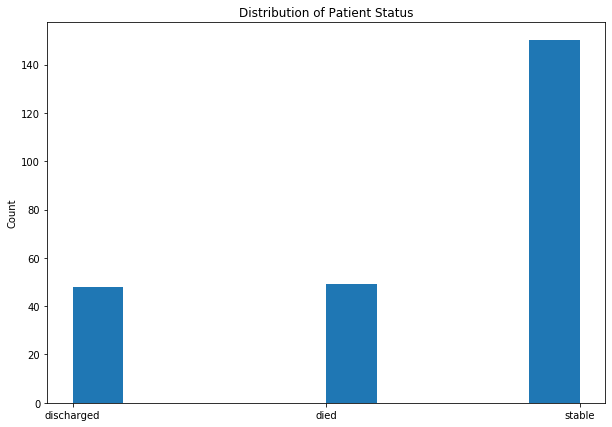

In [260]:
print(dfc['outcome'].unique())
plt.figure(figsize = [10,7])
plt.hist(dfc['outcome'].dropna())
plt.ylabel('Count')
plt.title('Distribution of Patient Status')

First, we simply look at the distribution of patient status. As 'stable' indicates a status more close to 'dischaged', we seem to have more cases that are likely discharged here. However, it seems that we have only a very small number of cases with known outcome, which makes sense as these data are more searched on an indivudual case and it would be hard to list number of distcharged/dead to the orginial dates when they are confirmed. 

However, from http://weekly.chinacdc.cn/news/TrackingtheEpidemic.htm we see that untl March 9th, there are in total 3,119 cases died and 58,600 cases recovered, where the deaths really constitude a very small portion of the real outcomes, we can say that the ratio shown in the graph is not representative.

### 2.age
preprocessing: as we examine the age data, we find that some values appear in range, and there are also two values below 1 which we don't know how to interepret, Thus, we fill the range with the middle value in the given age range and fill nan to values that we don't understand.

In [314]:
dfc_age

0        NaN
3        NaN
4        NaN
5        NaN
6        NaN
        ... 
98856    NaN
98857    NaN
98858    NaN
98859    NaN
98860    NaN
Name: age, Length: 42334, dtype: object

In [324]:
dfc_age = dfc['age'].copy()
for i in range(len(dfc_age)):
    if len(str(dfc_age[i])) >2:
        agee = str(dfc_age[i])
        if len(agee)==5:
            a = int(agee[:2])
            b = int(agee[3:5])
            if b-a >30:#when the age range is too large and imputing values might create bias
                dfc_age[i] = np.NaN
            else:#else we randomly choose a value in the range
                   dfc_age[i] = np.random.randint(a,b)
        else:#else the value is not interpretable
            dfc_age[i] = np.NaN
    else:
        dfc_age[i] = int(dfc_age[i])

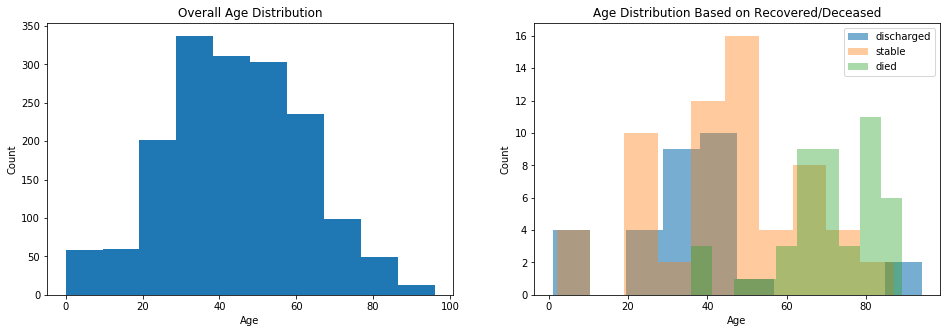

In [342]:
plt.figure(figsize = (16, 5))


plt.subplot(1, 2, 1)
plt.hist(dfc_age.dropna())
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Overall Age Distribution')

plt.subplot(1, 2, 2)
plt.hist(dfc_age[dfc['outcome'] == 'discharged'].dropna(), alpha = 0.6)
plt.hist(dfc_age[dfc['outcome'] == 'stable'].dropna(), alpha = 0.4)
plt.hist(dfc_age[dfc['outcome'] == 'died'].dropna(), alpha = 0.4)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution Based on Recovered/Deceased')
plt.legend(['discharged','stable', 'died'])

Next, we look at the distribution of age. We look at both the overall distribution of the dataset, as well as the difference in the distributions for individuals that have recovered and that died. We see that the ages have the highest frequency between about 40 and 70. We also see hard proof that the virus is more deadly to older people. We see a clear difference between the age of individuals who have recovered and who died. 

(Notice that though the data on the right constitutes only a small portion of the whole dataset, we still believe it captures the trend, especially as it shows the same trend as in other datasets. We might do a t-test to further validate our finding.)


### 3.gender

In [344]:
dfc['sex'].unique()

array(['male', nan, 'female'], dtype=object)

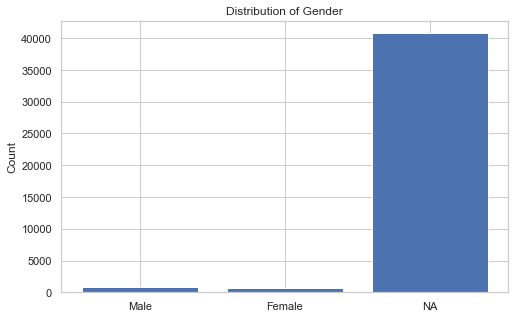

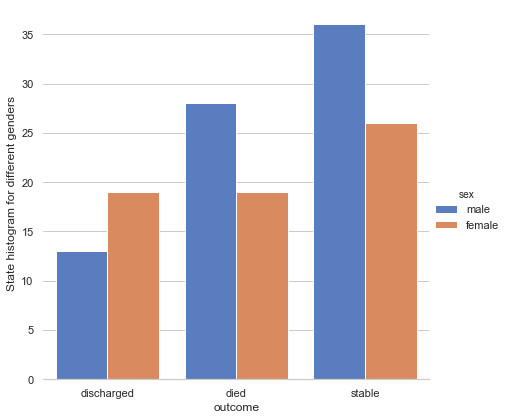

In [353]:
# There is one row where gender = 'W', I'll just ignore this
genderMale = np.sum(dfc['sex'] == 'male')
genderFemale = np.sum(dfc['sex'] == 'female')
genderNA = np.sum(dfc['sex'].isna())

plt.figure(figsize = (8, 5))

plt.bar(['Male', 'Female', 'NA'], [genderMale, genderFemale, genderNA])
plt.ylabel('Count')
plt.title('Distribution of Gender')


sns.set(style="whitegrid")
g = sns.catplot(x="outcome", kind="count", hue="sex", data=dfc,
                height=6, palette="muted")
g.despine(left=True)
g.set_ylabels("State histogram for different genders")



We also don't have lots of gender information, and from the collected data there doesn't seem to be a large difference between the outcomes for different genders. (These differences don't seem significant.)

## Anonymity and Privacy

Next, we analyze the $k$-anonymity of the dataset. We see that These data have a unique identifier which is `ID`, and also some quasi-identifiers including:

* age (this is the unadjusted age, containing both years and ranges)
* sex
* city/province (There are around 300 na values for cities, and no na value for province)
* admin_id ( Administrative unit ID of the lowest level available for the case reported)


In theory, these could be used to match an individual here to another dataset and uniquely identify that individual. Below, we calculate the $k$-anonymity of the dataset.

(Though the data descroption indicates that latitude,longitude might provide extra information than city/province, we find that not the case in data for China, so we don't include these variables here.)


In [470]:
dfKAnon = dfc.copy()

# Convert the nan's to strings since they're easier to deal with this way.
# We'll convert them back if needed later
naToStr(dfKAnon, dfKAnon.columns)

kAnonDict = {}
for i1 in range(len(dfKAnon)):
    row = dfKAnon.iloc[i1]
    key = (row['age'],row['sex'], row['city'], row['province'], row['admin_id'])
    if key not in kAnonDict:
        kAnonDict[key] = 0
    kAnonDict[key] += 1
    

In [471]:
# Sort based on the key, i.e. the number of times this pattern appeared in the dataset
sortedKAnonDict = sorted(kAnonDict.items(), key = operator.itemgetter(1))

In [398]:
# Top ten most common keys
sortedKAnonDict[-5:]

[(('NaN', 'NaN', 'Shenzhen City', 'Guangdong', 22.65389, 114.1291, 8076.0),
  702),
 (('NaN', 'NaN', 'Wenzhou City', 'Zhejiang', 27.90538, 120.4404, 9219.0), 990),
 (('NaN', 'NaN', 'Huanggang City', 'Hubei', 30.71988, 115.3378, 4363.0), 1130),
 (('NaN', 'NaN', 'Xiaogan City', 'Hubei', 31.12046, 113.8795, 9519.0), 1262),
 (('NaN', 'NaN', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 13487)]

In [399]:
# Top ten least common keys
sortedKAnonDict[:10]

[(('40-49',
   'female',
   'Toronto',
   'Ontario',
   43.71425228023435,
   -79.24526125793656,
   10364.0),
  1),
 (('70', 'male', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('76', 'female', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('72', 'male', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('79', 'male', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('55', 'male', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('87', 'male', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('66', 'female', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('78', 'male', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1),
 (('67', 'male', 'Wuhan City', 'Hubei', 30.62506, 114.3421, 9390.0), 1)]

In [472]:
# Calculate how many there are at each k level
kCounts = {}
for i in range(1,6):
    kCounts[i] = 0
for key, value in sortedKAnonDict:
    if value not in kCounts:
        kCounts[value] = 0
    kCounts[value] += 1
    
kCounts[1], kCounts[2], kCounts[3], kCounts[4], kCounts[5]

(27, 825, 2, 93, 0)

As we probably expected, the initial  𝑘 -anonymity of this dataset is 1. This isn't too surprising. However, we do see that there are only 20 that are totally unique, and only a handful that are below 5-anonymous. Also, by examining some of the unique records, they all have a unique age. I would thus start by converting ages to ranges.

#### 1. adjusting age range

In [401]:
dfc.age.unique()

array([nan, '66', '27', '17', '51', '68', '26', '30', '53', '35', '28',
       '58', '33', '50', '45', '24', '88', '29', '21', '78', '52', '60',
       '82', '7', '44', '69', '16', '47', '8', '43', '10', '55', '25',
       '38', '42', '34', '62', '39', '65', '73', '48', '54', '46', '96',
       '32', '63', '64', '57', '41', '20', '36', '80', '70', '61', '56',
       '37', '75', '94', '1', '22', '67', '15', '79', '23', '49', '40',
       '59', '31', '76', '40-49', '71', '87', '4', '2', '22-80', '5',
       '19-77', '21-72', '3', '77', '72', '16-80', '74', '23-72', '19',
       '81', '9', '12', '83', '36-45', '11', '84', '8-68', '50-59',
       '60-69', '70-82', '25-89', '85', '15-88', '89', '86', '21-39'],
      dtype=object)

Firstly, we want to divide ages to a reasonable range, such as every 10 years. We see that there are some existing ranges of ages including: '40-49','50-59', '60-69','70-82','21-39','36-45','22-80', '19-77','21-72','16-80','23-72', '25-89','15-88','8-68'
Here, '40-49','50-59', '60-69','70-82' are some valid ranges that we would like to use or that we can use; '21-39','36-45' are some age ranges providing some information but not enough, and the rest are similar to all age range. After some examination on the number of each cases with these ranges, we decide to keep the '21-39','36-45'labels as the don't seem to affect us acieving up to 5-anonymity, and we also change the rest of the ranges to NaNs.
We also change each age to a range of 10 years comtaining the given age.

In [443]:
agee = dfc.age.copy()
for i in range(len(agee)):
    if len(str(agee[i])) <3:
        if pd.notna(agee[i]):
            init = int(agee[i])//10
            if init >= 7:
                agee[i] = 'above 70'
            else:
                agee[i] = str(init*10) +'-'+str(init*10+9)
            
    else:
        if agee[i] in ['22-80', '19-77','21-72','16-80','23-72', '25-89','15-88','8-68']:
            agee[i] = 'NaN'
        else:
            if agee[i] == '70-82':
                agee[i] = 'above 70'
        

In [446]:
dfc['age_range'] = agee

In [454]:
dfKAnon = dfc.copy()

# Convert the nan's to strings since they're easier to deal with this way.
# We'll convert them back if needed later
naToStr(dfKAnon, dfKAnon.columns)

kAnonDict = {}
for i1 in range(len(dfKAnon)):
    row = dfKAnon.iloc[i1]
    key = (row['age_range'],row['sex'], row['city'], row['province'], row['latitude'], row['longitude'], row['admin_id'])
    if key not in kAnonDict:
        kAnonDict[key] = 0
    kAnonDict[key] += 1

sortedKAnonDict = sorted(kAnonDict.items(), key = operator.itemgetter(1))
kCounts = {}
for i in range(1,6):
    kCounts[i] = 0
for key, value in sortedKAnonDict:
    if value not in kCounts:
        kCounts[value] = 0
    kCounts[value] += 1
    
kCounts[1], kCounts[2], kCounts[3], kCounts[4], kCounts[5]

(3, 561, 3, 137, 0)

#### 2. about gender

Gender is some variable that would provide some information about the patient, and we do want to include this variable here. However, at the same time, the reaosn why gender make some key indices unique is that there are too many missing data in the dataset. While we might randomly assign genders to some data points we have to reduce the anonymity, we beieve that it would be fine to just ignore gender when calculating anonymity here.

In [478]:
dfKAnon = dfc.copy()

# Convert the nan's to strings since they're easier to deal with this way.
# We'll convert them back if needed later
naToStr(dfKAnon, dfKAnon.columns)

kAnonDict = {}
for i1 in range(len(dfKAnon)):
    row = dfKAnon.iloc[i1]
    key = (row['age_range'], row['city'], row['province'], row['admin_id']) #deleted row['sex']
    if key not in kAnonDict:
        kAnonDict[key] = 0
    kAnonDict[key] += 1

sortedKAnonDict = sorted(kAnonDict.items(), key = operator.itemgetter(1))
kCounts = {}
for i in range(1,6):
    kCounts[i] = 0
for key, value in sortedKAnonDict:
    if value not in kCounts:
        kCounts[value] = 0
    kCounts[value] += 1
    
kCounts[1], kCounts[2], kCounts[3], kCounts[4], kCounts[5]

(2, 420, 1, 142, 0)

In [475]:
sortedKAnonDict[:10]

[(('40-49', 'Toronto', 'Ontario', 10364.0), 1),
 (('60-69', "Yuan'an County, Yichang City", 'Hubei', 9933.0), 1),
 (('NaN', 'Shek Lei', 'Hong Kong', 8051.0), 2),
 (('60-69', 'Zhenlai County, Baicheng City', 'Jilin', 10120.0), 2),
 (('20-29', 'Longshan District, Liaoyuan City', 'Jilin', 5694.0), 2),
 (('10-19', 'Gongzhuling City, Siping City', 'Jilin', 3653.0), 2),
 (('60-69', 'Changchun City', 'Jilin', 2070.0), 2),
 (('50-59', 'Tonghua City', 'Jilin', 8708.0), 2),
 (('30-39', 'Meihekou City, Tonghua City', 'Jilin', 6101.0), 2),
 (('NaN', 'Yanbian Prefecture', 'Jilin', 9707.0), 2)]

We checked upon these datasets and find that we can't increase anonymity by changing the `city` to NaN for these values. And the variables cannot really be further generalized in this case. Thus, we would choose to drop these records. This would not make too much change as we have around 40,000 data points in total and here we only lose less than a thousant data points. 

Another thing we might do is to just leave the age range and only look at the location data and drop those values with unique/less frequent keys for these location identifiers. The reason we can do so is that we have so many missing data for age ranges too, which means that though they appear less frequently their anonymity might still be high among all dataset.

In [508]:
threeAnonDF = dfKAnon.copy()
fiveAnonDF = dfKAnon.copy()

for key, value in kAnonDict.items():
    age, city, province,admin_id = key
    
    indices = ~((threeAnonDF['age_range'] == age) & (threeAnonDF['city'] == city) & (threeAnonDF['province'] == province) \
             & (threeAnonDF['admin_id'] == admin_id))
    
    if value <= 3:
        threeAnonDF = threeAnonDF[indices]
        
    if value <= 5:
        fiveAnonDF = fiveAnonDF[indices]

/Users/qiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [509]:
len(dfc),len(threeAnonDF), len(fiveAnonDF)

(42334, 41489, 40921)

## Examination

As we have very limited amount of known outcomes from the dataset, it's almost unlikely that we can correctly predict outcomes. However, we could still check the relation between some variables and the outcomes before and after we increase anonymity is still maintained.

Notice that we are only comparing with 3- and 5-anonymity data as the 4- and 5-anonymity data are basically the same.

[nan 'discharged' 'died' 'stable']


Text(0.5, 1.0, 'Distribution in 5-anonymous Dataset')

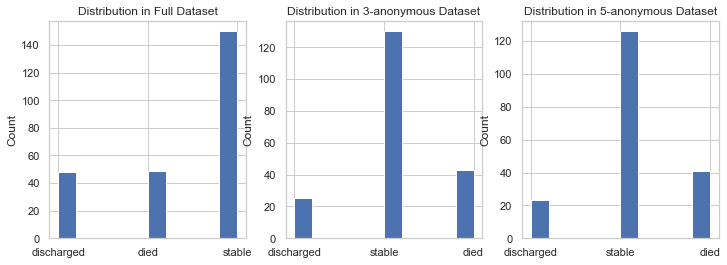

In [510]:
print(dfc['outcome'].unique())
plt.figure(figsize = [12,4])
plt.subplot(1, 3, 1)
plt.hist(dfc['outcome'].dropna())
plt.ylabel('Count')
plt.title('Distribution in Full Dataset')

plt.subplot(1, 3, 2)
plt.hist(threeAnonDF.loc[threeAnonDF['outcome'] != 'NaN', 'outcome'])
plt.ylabel('Count')
plt.title('Distribution in 3-anonymous Dataset')


plt.subplot(1, 3, 3)
plt.hist(fiveAnonDF.loc[fiveAnonDF['outcome'] != 'NaN', 'outcome'])
plt.ylabel('Count')
plt.title('Distribution in 5-anonymous Dataset')


In [524]:
current_data.age_range.unique()

array(['40-49', '30-39', '50-59', '20-29', '60-69', 'above 70'],
      dtype=object)

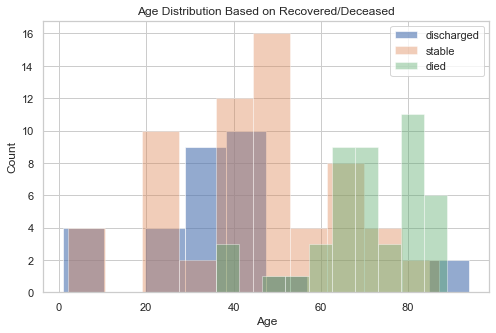

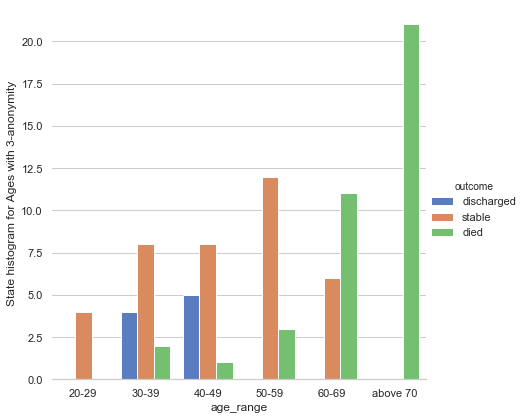

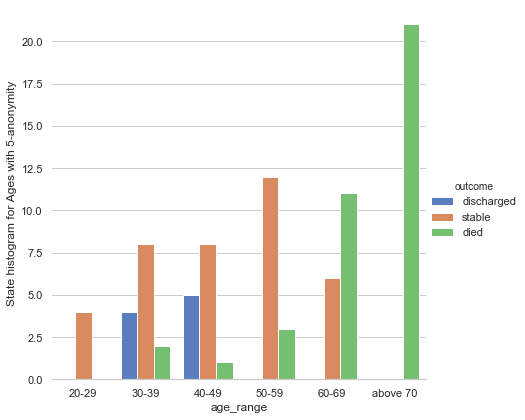

In [525]:
plt.figure(figsize = (8, 5))


plt.hist(dfc_age[dfc['outcome'] == 'discharged'].dropna(), alpha = 0.6)
plt.hist(dfc_age[dfc['outcome'] == 'stable'].dropna(), alpha = 0.4)
plt.hist(dfc_age[dfc['outcome'] == 'died'].dropna(), alpha = 0.4)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution Based on Recovered/Deceased')
plt.legend(['discharged','stable', 'died'])

current_data = threeAnonDF.loc[(threeAnonDF['outcome'] != 'NaN') & (fiveAnonDF['age_range'] != 'NaN')]
g = sns.catplot(x="age_range", kind="count", hue="outcome", data=current_data,
                height=6, palette="muted",order = [ '20-29', '30-39','40-49', '50-59', '60-69', 'above 70'])
g.despine(left=True)
g.set_ylabels("State histogram for Ages with 3-anonymity")


current_data = fiveAnonDF.loc[(fiveAnonDF['outcome'] != 'NaN') & (fiveAnonDF['age_range'] != 'NaN')]
g2 = sns.catplot(x="age_range", kind="count", hue="outcome", data=current_data,
                height=6, palette="muted",order = [ '20-29', '30-39','40-49', '50-59', '60-69', 'above 70'])
g2.despine(left=True)
g2.set_ylabels("State histogram for Ages with 5-anonymity")


### United State

In [539]:
dfu = dates_confirm[1]
dfu=dfu.reset_index(drop = True)

In [540]:
dfu.age.unique()

array([nan, '30-39', '39', '40-49', '60-69', '80-89', '90-99', '70-79',
       '20-29', '46', '45', '70-70', '50-59', '10-19', '29', '22', '63',
       '71', '56', '44', '18-65', '32', '60-70', '27', '60-', '18-50',
       '61', '66', '54', '77', '75', '65', '67', '55', '74', '18-49',
       '41-60', '61-80', '69', '47', '18-60', '81', '60-99', '70',
       '40-50', '40-69', '30-69', '40-45', '60', '68', '0-9', '64', '73',
       '79', '54-56', '0-19', '20-30', '57', '50-99', '18-20', '17-66',
       '65-', '53', '18-99', '34-66', '55-74', '75-', '35-54', '55-',
       '0-18', '18-', '31', '51', '50', '42', '24', '83', '26', '49',
       '36', '48', '74-76', '27-29', '50-60', '41', '62', '59', '37',
       '20', '19', '58', '13-19', '30-40', '70-100', '0-60', '18 - 100',
       '0-20', '72', '88', '28', '25', '52', '21', '76', '89', '17', '18',
       '43', '30', '35', '40', '80', '30-70', '50-100', '60-100', '23',
       '94', '50-', '33', '34', '91', '87', '93', '82', '38', '84', '78

In [558]:
dfu.loc[dfu.age ==46.0,'age'] = '46'
dfu.loc[dfu.age ==45.0,'age'] = '45'

dfu_age = dfu['age'].copy()
for i in range(len(dfu_age)):
    if dfu_age[i] is not np.NaN:
        ww = str(dfu_age[i]).split('-')
        if len(ww) > 1 and len(ww[1]) > 1:
            a= int(ww[0])
            b = int(ww[1])
            dfu_age[i] = np.random.randint(a,b+1)
        else:
            if ww[0] == 'nan':
                dfu_age[i] = np.NaN
            else:
                dfu_age[i] = int(ww[0])
    else:
        dfu_age[i] = np.NaN
   

In [542]:
dfu['outcome'].unique()

array([nan, 'Discharged from hospital', 'not hospitalized', 'recovered',
       'recovering at home 03.03.2020', 'death', 'died', 'Death'],
      dtype=object)

In [543]:
dfu.loc[dfu.outcome =='Discharged from hospital','outcome'] = 'recovered'
dfu.loc[dfu.outcome == 'recovering at home 03.03.2020','outcome'] = 'recovered'
dfu.loc[dfu.outcome == 'death','outcome'] = 'died'
dfu.loc[dfu.outcome == 'Death','outcome'] = 'died'
dfu['outcome'].unique()

array([nan, 'recovered', 'not hospitalized', 'died'], dtype=object)

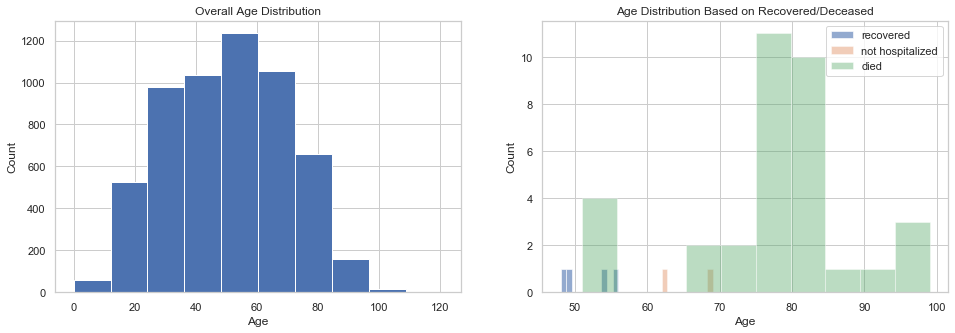

In [559]:
plt.figure(figsize = (16, 5))


plt.subplot(1, 2, 1)
plt.hist(dfu_age.dropna())
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Overall Age Distribution')

plt.subplot(1, 2, 2)
plt.hist(dfu_age[dfu['outcome'] == 'recovered'].dropna(), alpha = 0.6)
plt.hist(dfu_age[dfu['outcome'] == 'not hospitalized'].dropna(), alpha = 0.4)
plt.hist(dfu_age[dfu['outcome'] == 'died'].dropna(), alpha = 0.4)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution Based on Recovered/Deceased')
plt.legend(['recovered','not hospitalized', 'died'])

### Italy

In [562]:
print('Death count: ', sum(dates_confirm[0]['outcome'] == 'death'))
print('Discharge count:', sum(dates_confirm[0]['outcome'] == 'discharge'))
print('Total: 158004')

Death count:  3
Discharge count: 4
Total: 158004
